In [1]:
# define logging and working directory
import os
import logging
import platform
import SimpleITK as sitk
import glob
import random
from collections import Counter
import matplotlib.pyplot as plt
import keras
from skimage.transform import resize
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from time import time

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from ipywidgets import interact
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# setup working directory
print(os.getcwd())
# change working directory to project root - neccessary for jupyter notebooks
if platform.system() is "Windows":
    os.chdir('E:\\sven\\git\\cardio')
else:
    os.chdir('/Users/minority/Code/Git/cardio')
print(os.getcwd())


from src.utils.utils_io import Console_and_file_logger, ensure_dir
from src.utils.myshow import myshow, myshow3d
from src.visualization.visualize import plot_3d_vol, plot_4d_vol, show_slice, show_slice_transparent, show_2D_or_3D
from src.data.dataset import get_metadata_maybe, filter_4d_vol, describe_sitk
Console_and_file_logger('2D_DataGenerator_tests', logging.INFO)




2019-08-29 15:05:43,906 INFO -------------------- Start --------------------
2019-08-29 15:05:43,906 INFO Working directory: E:\sven\git\cardio.
2019-08-29 15:05:43,906 INFO Log file: ./logs/2D_DataGenerator_tests.log


E:\sven\git\cardio\notebooks\dataset
E:\sven\git\cardio


In [2]:
# helpers
def get_img_msk_files_from_split_dir(path):
    images = sorted(glob.glob(os.path.join(path, '*img.nrrd')))
    masks = sorted(glob.glob(os.path.join(path, '*msk.nrrd')))
    return images, masks

def get_patient_name_from_file(file_):
    return os.path.basename(file_).split('.')[0].split('_')[0]

# Get all 2D image and mask files

In [3]:
import_path = 'data/raw/tetra/2D/train/'
images, masks = get_img_msk_files_from_split_dir(import_path)
assert(len(images) == len(masks))
print(len(images))

10342


# Visualize any mask

In [4]:
@interact
def plot_masks(path=masks):
    
    logging.info(path)
    sitk_img = sitk.ReadImage(path, sitk.sitkFloat32)
    describe_sitk(sitk_img)
    mask_nda = sitk.GetArrayFromImage(sitk_img)
    print(mask_nda.shape)
    show_slice(mask=mask_nda)

interactive(children=(Dropdown(description='path', options=('data/raw/tetra/2D/train\\0003-04NEJQUZ-2007-03-13…

# Select path

In [5]:
import_path = ""
images = ""
masks = ""
@interact
def select_path(import_p = 'data/raw/tetra/2D/train/', done=False):
    if done:
        global import_path, images, masks
        import_path = import_p
        images, masks = get_img_msk_files_from_split_dir(import_p)
        assert(len(images) == len(masks))
        logging.info('Files found: {}'.format(len(images)))

interactive(children=(Text(value='data/raw/tetra/2D/train/', description='import_p'), Checkbox(value=False, de…

# Select patient

In [7]:
patient = ""
p_masks = ""
p_images = ""
@interact
def select_patient(p=list(set([get_patient_name_from_file(file) for file in images]))):
    global patient, p_masks, p_images
    patient = p
    # filter images by patient
    p_masks = [s for s in masks if p in s]
    p_images = [s for s in images if p in s]
    logging.info('Patient: {} with {} masks'.format(patient, len(p_masks)))


interactive(children=(Dropdown(description='p', options=('0275-D8RUZJ8N-2006-09-22', '0144-76RJ3Z26-2006-11-23…

# Select 2D mask and visualize

In [6]:
@interact
def plot_masks(slice_=p_masks):
    
    logging.info(slice_)
    sitk_msk = sitk.ReadImage(slice_, sitk.sitkInt16)
    describe_sitk(sitk_msk)
    nda_msk = sitk.GetArrayFromImage(sitk_msk)
    plt.imshow(nda_msk)
    plt.show()
    # get image for mask
    image_f = slice_.replace('msk', 'img')
    sitk_img = sitk.ReadImage(image_f, sitk.sitkInt16)
    describe_sitk(sitk_img)
    nda_img = sitk.GetArrayFromImage(sitk_img)
    plt.imshow(nda_img)
    plt.show()
    show_slice_transparent(img=nda_img, mask=nda_msk)

interactive(children=(Dropdown(description='slice_', options=('data/raw/tetra/2D/train\\0207-A54LC7D6-2008-01-…

# Create a Datagenerator and visualize one batch

In [8]:
# create a config

# image params
DIM = [12,224, 224]
SPACING = [8,1, 1]
# Greyscale images
IMG_CHANNELS = 1
# RV = 1 = Y[...,0] 
# Myo = 2 = Y[...,1] 
# LV = 3 = Y[...,2]
MASK_VALUES = [0, 1, 2, 3]  
MASK_CLASSES = len(MASK_VALUES)
AUGMENT = False
AUGMENT_GRID = True
RESAMPLE = False
SHUFFLE = False
SPACING_X = 1.00
SPACING_Y = 1.00
SEED = 42
BATCHSIZE =  1 # 64, 16, 1
SCALER = 'MinMax'

AUGMENT_IMAGE_PARAMS = dict(  # samplewise_center=True,
                # samplewise_std_normalization=True,
                #horizontal_flip=True,
                #vertical_flip=True,
                #rotation_range=30,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.1,
                # fill_mode='nearest'
            )
AUGMENT_MASK_PARAMS = dict(  # samplewise_center=True,
                # samplewise_std_normalization=True,
                #horizontal_flip=True,
                #vertical_flip=True,
                #rotation_range=30,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.1,
                fill_mode='nearest',
                # dtype=np.bool
            )
config = dict(((key, value) for key, value in locals().items()
               if key.isupper() and key not in ['HTML', 'K']))
config

{'DIM': [12, 224, 224],
 'SPACING': [8, 1, 1],
 'IMG_CHANNELS': 1,
 'MASK_VALUES': [0, 1, 2, 3],
 'MASK_CLASSES': 4,
 'AUGMENT': False,
 'AUGMENT_GRID': True,
 'RESAMPLE': False,
 'SHUFFLE': False,
 'SPACING_X': 1.0,
 'SPACING_Y': 1.0,
 'SEED': 42,
 'BATCHSIZE': 1,
 'SCALER': 'MinMax',
 'AUGMENT_IMAGE_PARAMS': {'width_shift_range': 0.1,
  'height_shift_range': 0.1,
  'zoom_range': 0.1},
 'AUGMENT_MASK_PARAMS': {'width_shift_range': 0.1,
  'height_shift_range': 0.1,
  'zoom_range': 0.1,
  'fill_mode': 'nearest'}}

In [18]:
from src.data.generators import DataGenerator2D
from src.data.dataset import get_img_msk_files_from_split_dir
images_f, masks_f = get_img_msk_files_from_split_dir('data/raw/tetra/3D/val/')
len(images_f)

130

In [19]:
# create one Datagenerator and visualize one batch
@interact
def interact_show_with_generator(selected_batch=(0, int(len(images_f)/config['BATCHSIZE'])-1), selected_img=(0, config['BATCHSIZE']-1)):
    #selected_img = 70

    logging.getLogger().setLevel(logging.DEBUG)
    mpl_logger = logging.getLogger('matplotlib') 
    mpl_logger.setLevel(logging.WARNING) 

    batch_generator = DataGenerator2D(images_f, masks_f, config)
    t0 = time()
    x, y = batch_generator.__getitem__(selected_batch)
    logging.info('loading batch: {}, took {:0.3f} sec'.format(selected_batch, time()- t0))
    logging.info('X shape: {}'.format(x.shape))
    logging.info('Y shape: {}'.format(y.shape))
    # plot x and y
    # errors with 3d data, caused by channels
    #ax = show_2D_or_3D(x[selected_img], y[selected_img])

    #show_slice(x[0], y[0])

interactive(children=(IntSlider(value=64, description='selected_batch', max=129), IntSlider(value=0, descripti…

In [9]:
img = sitk.ReadImage(images_f[0], sitk.sitkFloat32)

In [52]:
img.GetPixelIDTypeAsString()

'32-bit float'

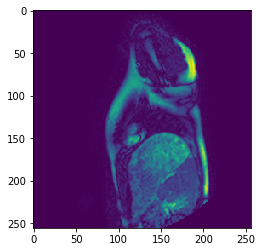

In [53]:
plt.imshow(sitk.GetArrayFromImage(img))

# Test the ACDC data slit

In [5]:
fold = 0


df_folds = pd.read_csv('reports/kfolds_data/2D/unet_acdc_spacing1_batch32_drop04_batchnorm_minmax_kfold/df_kfold_acdc.csv')

# select the corresponding fold of data
df_fold = df_folds[df_folds['fold'] == fold]

#path_as_string = config.get('EXPERIMENT', 'temp') + dataset + '_' + area + '_' + str(fold) + '_{}'.format(modality)
#path_as_string_test = config.get('EXPERIMENT', 'temp') + dataset + '_' + area + '_' + str(fold) + '_test'

# load filenames

# get the current folded train/validation data
df_fold = df_folds[df_folds['fold'] == fold]
X_train = sorted(df_fold[df_fold['modality'] == 'train']['x_path'])
Y_train = sorted(df_fold[df_fold['modality'] == 'train']['y_path'])
X_test = sorted(df_fold[df_fold['modality'] == 'test']['x_path'])
Y_test = sorted(df_fold[df_fold['modality'] == 'test']['y_path'])

X_test = X_train + X_test
Y_test = Y_train + Y_test

In [6]:
# create one Datagenerator and visualize one batch
@interact
def interact_show_with_generator(selected_batch=(0, int(len(X_test)/config['BATCHSIZE'])-1), selected_img=(0, config['BATCHSIZE']-1)):
    #selected_img = 70

    logging.getLogger().setLevel(logging.INFO)
    mpl_logger = logging.getLogger('matplotlib') 
    mpl_logger.setLevel(logging.WARNING) 

    batch_generator = DataGenerator2D(X_test, Y_test, config)
    t0 = time()
    x, y = batch_generator.__getitem__(selected_batch)
    logging.info('loading batch: {}, took {:0.3f} sec'.format(selected_batch, time()- t0))
    logging.info('X shape: {}'.format(x.shape))
    logging.info('Y shape: {}'.format(y.shape))
    # plot x and y
    ax = show_slice_transparent(x[selected_img], y[selected_img])

interactive(children=(IntSlider(value=941, description='selected_batch', max=1883), IntSlider(value=0, descrip…

In [54]:
img = sitk.ReadImage(X_test[0], sitk)

In [55]:
img.GetPixelIDTypeAsString()

'16-bit signed integer'

# compare reading speed nii.gz vs nrrd files

In [38]:
%%timeit
img = sitk.ReadImage('data/raw/ACDC/original/all/patient001/patient001_frame01_gt.nii.gz')

4.19 ms ± 518 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
img = sitk.ReadImage('data/raw/ACDC/original/all/patient001/patient001_frame01_gt.nii.gz')
sitk.WriteImage(img, 'data/raw/ACDC/original/all/patient001/patient001_frame01_gt.nrrd')

In [39]:
%%timeit
img = sitk.ReadImage('data/raw/ACDC/original/all/patient001/patient001_frame01_gt.nrrd')

2.04 ms ± 393 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
%%timeit
img = sitk.ReadImage('data/raw/tetra/2D/val/0055-2V8HJLHN-2005-08-30__t0_z8_img.nrrd')
nda = sitk.GetArrayFromImage(img)
ninenine_q = np.quantile(nda.flatten(), .999, overwrite_input=False)
nda = np.clip(nda, 0, ninenine_q)
ninenine_q

7.39 ms ± 453 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
%%timeit
img = sitk.ReadImage('data/raw/tetra/2D/val/0055-2V8HJLHN-2005-08-30__t0_z8_img.nrrd')
nda = sitk.GetArrayFromImage(img)
nda = np.clip(nda, 0, 2000)


4.48 ms ± 489 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

# Test speed of different scalings

In [47]:
%%timeit
img_nda = sitk.GetArrayFromImage(sitk.ReadImage('data/raw/tetra/2D/val/0055-2V8HJLHN-2005-08-30__t0_z8_img.nrrd'))
StandardScaler(copy=True, with_mean=True, with_std=True).fit_transform(img_nda)

7.72 ms ± 515 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
%%timeit
img_nda = sitk.GetArrayFromImage(sitk.ReadImage('data/raw/tetra/2D/val/0055-2V8HJLHN-2005-08-30__t0_z8_img.nrrd'))
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,with_scaling=True).fit_transform(img_nda)

76.4 ms ± 7.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [49]:
%%timeit
img_nda = sitk.GetArrayFromImage(sitk.ReadImage('data/raw/tetra/2D/val/0055-2V8HJLHN-2005-08-30__t0_z8_img.nrrd'))
(img_nda -img_nda.min() ) / (img_nda.max() - img_nda.min())

5.46 ms ± 521 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [51]:
%%timeit
img_nda = sitk.GetArrayFromImage(sitk.ReadImage('data/raw/tetra/2D/val/0055-2V8HJLHN-2005-08-30__t0_z8_img.nrrd'))
MinMaxScaler(copy=True).fit_transform(img_nda)

6.47 ms ± 652 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
# test binary mask creation speed
%%timeit
nda_c = transform_to_binary_mask_2d(nda)

nda_c.shape

1.82 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
# test binary mask creation speed --> without np.max
%%timeit
nda_c = transform_to_binary_mask_2d(nda)
nda_c.shape

762 µs ± 60.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
